# Projet : Le Jeu De La Vie

Présentation de Ashley , Arthur Brouchon, Jeremie Gallula et Léo Triffault

Cette présentation a pour but de faire le tour de toutes les fonctionnalitées principales présentes dans le projet. 
Nous retraceront le fonctionnement du projet dans l'ordre présenté dans le sujet avec pour chaque partie une rapide explication du fonctionnement et des choix pris pour sa mise en place.

**Partie 1 : Moteur du jeu**

Une première simple execution de notre programme :

In [7]:
import os

os.system("C:\wamp64\www\Jeu-de-la-vie\main.py")

1

Le moteur fonctionne en suivant un certain nombre de paramètres de base, ceux-ci sont initialisés au lancement du programme.

Juste après cette étape, nous affichons le menu principal de l'application :

In [2]:
import numpy as np
import pygame
import time
from moteur_jeu.gestion_matrice import init_matrix
from moteur_jeu.evaluation import evaluate
from interface.affichage_grille import draw_matrix
from interface.boutons import draw_button
from interface.ecran_demarrage import start_screen, select_save_screen, save_game_screen, confirmation_screen
from sauvegarde.chargement import load_matrix, list_saves
from sauvegarde.sauvegarde import save_matrix
from analyse_donnees.analyse import save_data, creer_graph, creer_graph_exec
from interface.stats import draw_value


pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
# Initialiser pygame
pygame.init()

# Dimensions de la fenêtre et des cellules
TAILLE_CELLULE = 5  # Taille de chaque cellule dans la grille
TAILLE_GRILLE = 100  # Nombre de cellules par côté
LARGEUR = HAUTEUR = TAILLE_GRILLE * TAILLE_CELLULE *1.5 # Taille de la grille
LARGEUR_TOTALE = LARGEUR  # Largeur totale de la fenêtre
HAUTEUR_TOTALE = HAUTEUR + 100  # Hauteur totale de la fenêtre avec espace pour les boutons

# Créer la fenêtre du jeu
screen = pygame.display.set_mode((LARGEUR_TOTALE, HAUTEUR_TOTALE))
pygame.display.set_caption("Jeu de la Vie")

# Définition des couleurs et de la police
COULEUR_VIVANT = (0, 255, 0)  # Couleur pour les cellules vivantes
COULEUR_MORT = (0, 0, 0)  # Couleur pour les cellules mortes
COULEUR_GRILLE = (40, 40, 40)  # Couleur des lignes de la grille
font = pygame.font.Font(None, 36)  # Police pour les textes

# Boucle du menu principal
while True:
    # Afficher l'écran de démarrage avec les options Nouvelle Partie et Charger Partie
    button_new_game, button_load_game = start_screen(screen, LARGEUR, HAUTEUR, font)
    selected_matrix = None  # Initialisation de la matrice sélectionnée

    # Boucle pour gérer les événements dans le menu principal
    menu_running = True
    while menu_running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                # Quitter le jeu si l'utilisateur ferme la fenêtre
                pygame.quit()
                exit()
            elif event.type == pygame.MOUSEBUTTONDOWN:
                # Gérer les clics de souris
                if button_new_game.collidepoint(event.pos):
                    # Si Nouvelle Partie est sélectionnée
                    selected_matrix = init_matrix(TAILLE_GRILLE)
                    main_game_loop(selected_matrix)  # Lancer la boucle de jeu
                    menu_running = False  # Sortir de la boucle de menu pour revenir au jeu
                elif button_load_game.collidepoint(event.pos):
                    # Si Charger Partie est sélectionnée
                    filename = select_save_screen(screen, LARGEUR, HAUTEUR, font)
                    if filename:
                        # Charger la matrice depuis le fichier sélectionné
                        selected_matrix = load_matrix(filename)
                        main_game_loop(selected_matrix, save_filename=filename)  # Lancer le jeu avec sauvegarde directe
                        menu_running = False  # Sortir de la boucle de menu pour revenir au jeu
        # Mettre à jour l'affichage du menu principal
        pygame.display.flip()

Ce menu propose deux option, lancer une nouvelle partie ou en charger une préalablement sauvegardée.

La sauvegarde constituant une autre partie, nous la présenterons dans un autre temps

In [1]:
def main_game_loop(matrix, save_filename=None):
    
    #Boucle principale du jeu de la vie.
    #Si save_filename est fourni, le jeu sauvegarde directement dans ce fichier lors de l'utilisation du bouton Sauvegarder.
    
    paused = False  # Variable pour contrôler la pause du jeu
    running = True  # Variable pour contrôler la boucle principale du jeu
    clock = pygame.time.Clock()  # Objet pour contrôler la vitesse d'exécution
    debut = time.perf_counter() # Calculer le temps d'execution
    temps = 0 # Initialiser le temps d'execution à 0
    temps_paused = 0 # Initialiser le temps perdu dans les pauses
    data = [[0],[0],[0],[TAILLE_GRILLE]]
    taille_cellule = TAILLE_CELLULE
    exect_time = 0

    while running:
        # Remplir l'arrière-plan de la fenêtre
        screen.fill(COULEUR_MORT)
        
        # Afficher la grille de jeu
        draw_matrix(screen, matrix, taille_cellule, COULEUR_VIVANT, COULEUR_MORT, COULEUR_GRILLE)
        
        # Afficher les boutons Pause/Play, Zoom+/Zoom- et Sauvegarder
        button_pause_rect = draw_button(screen, font, "Play" if paused else "Pause", 10, HAUTEUR + 10,)
        button_save_rect = draw_button(screen, font, "Sauvegarder", 10, HAUTEUR + 50)
        draw_value(screen, "Temps : ", str(temps), 10, 5)
        draw_value(screen, "Temps de calcul : ", str(exect_time), 120,5)
        button_zoom_in_rect = draw_button(screen, font, "Zoom +", 200, HAUTEUR + 10)
        button_zoom_out_rect = draw_button(screen, font, "Zoom -", 200, HAUTEUR + 50)
        
        # Mettre à jour l'affichage
        pygame.display.flip()

        # Si le jeu n'est pas en pause, évaluer la prochaine génération de la matrice
        if not paused:
            # Noter le moment de début du calcul des cellules 
            exec_time_start = time.perf_counter()
            
            matrix = evaluate(matrix)
            # Calculer le temps de calcul des cellules
            exect_time = round(time.perf_counter() - exec_time_start, 5) 

            # Calculer le temps d'execution depuis le début
            temps = round(temps_paused + time.perf_counter() - debut, 2)

        # Gérer les événements utilisateur
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                # Quitter le jeu si l'utilisateur ferme la fenêtre
                pygame.quit()
                ### creer_graph(data)
                ### creer_graph_exec(data)
                exit()
            elif event.type == pygame.MOUSEBUTTONDOWN:
                # Gérer les clics de souris
                x, y = pygame.mouse.get_pos()
                if button_pause_rect.collidepoint(x, y):
                    # Basculer l'état de pause si on clique sur le bouton Pause/Play
                    paused = not paused
                    if paused == False:
                        debut = time.perf_counter()
                        temps_paused = temps
                elif button_save_rect.collidepoint(x, y):
                    # Sauvegarder la partie
                    if save_filename:
                        # Si un fichier de sauvegarde est déjà défini (partie chargée), sauvegarder directement
                        save_matrix(matrix, filename=save_filename)
                    else:
                        # Sinon, demander un nom pour la sauvegarde (nouvelle partie)
                        save_filename = save_game_screen(screen, LARGEUR, HAUTEUR, font, matrix)
                    
                    # Afficher l'écran de confirmation après la sauvegarde
                    choice = confirmation_screen(screen, LARGEUR, HAUTEUR, font)
                    if choice == "menu":
                        # Retourner au menu principal si l'utilisateur le souhaite
                        return
                    
                     # Gestion des clics sur les boutons de zoom
                elif button_zoom_in_rect.collidepoint(x, y):
                    taille_cellule = min(taille_cellule + 2, 40)  # Zoom avant (limité à 40)
                elif button_zoom_out_rect.collidepoint(x, y):
                    taille_cellule = max(taille_cellule - 2, 2)  # Zoom arrière (limité à 2)
                elif y < TAILLE_GRILLE * taille_cellule and x < TAILLE_GRILLE * taille_cellule:
                    # Permet à l'utilisateur de cliquer sur une cellule pour la rendre vivante ou morte
                    n = y // taille_cellule
                    m = x // taille_cellule
                    matrix[n, m] = 1 if matrix[n, m] == 0 else 0
        # Set les données pour analyse
        data = save_data(temps, data, exect_time, matrix)

        # Limiter la vitesse de la boucle
        clock.tick(10)


A chaque itération de la boucle, l'entièreté de la grille est recalculée selon les règles avant d'afficher la nouvelle grille mais nous entrerons plus en détaille dans cette partie en étudiant l'optimisation

**Partie 2 : Interface**

L'interface du jeu est entièrement faite à l'aide de la bibliothèque Pygames.                                       
C'est avec elle que l'on affiche le menu au début du jeu et le jeu en lui même.

Premièrement, nous pouvons entrer plus en détail dans l'affichage de la grille en elle même :

In [ ]:
def draw_grid(screen, largeur, hauteur, taille_cellule, couleur_grille):
    for x in range(0, largeur, taille_cellule):
        pygame.draw.line(screen, couleur_grille, (x, 0), (x, hauteur))
    for y in range(0, hauteur, taille_cellule):
        pygame.draw.line(screen, couleur_grille, (0, y), (largeur, y))

def draw_matrix(screen, matrix, taille_cellule, couleur_vivant, couleur_mort, couleur_grille):
    rows, cols = matrix.shape
    for n in range(rows):
        for m in range(cols):
            rect = pygame.Rect(m * taille_cellule, n * taille_cellule, taille_cellule, taille_cellule)
            if matrix[n, m] == 1:
                pygame.draw.rect(screen, couleur_vivant, rect)
            else:
                pygame.draw.rect(screen, couleur_mort, rect)
    draw_grid(screen, rows * taille_cellule, cols * taille_cellule, taille_cellule, couleur_grille)

Ainsi que les boutons : 

In [2]:
def draw_button(screen, font, text, x, y, padding=10, height=30):
    # Rendre le texte pour obtenir sa taille
    text_surface = font.render(text, True, (255, 255, 255))
    text_rect = text_surface.get_rect()

    # Ajuster la largeur du bouton en fonction de la largeur du texte, avec un padding
    width = text_rect.width + padding * 2
    button_rect = pygame.Rect(x, y, width, height)
    
    # Dessiner le rectangle du bouton et le texte
    pygame.draw.rect(screen, (70, 130, 180), button_rect)
    text_rect.center = button_rect.center
    screen.blit(text_surface, text_rect)

    return button_rect


**Partie 3 : Sauvegarde et chargement**

In [ ]:
import os
import numpy as np

# Sauvegarde l'état de la grille dans un fichier .txt.
def save_matrix(matrix, filename=None):
 #matrix: La matrice représentant l'état actuel de la grille.
 #filename: Le nom du fichier où sauvegarder la grille.
    if filename is None:
        filename = input("Entrez le nom de la sauvegarde: ") + ".txt"

    with open(filename, 'w') as f:
        for row in matrix:
            f.write(" ".join(map(str, row)) + "\n")
    print(f"Matrice sauvegardée dans {filename}")

grille = np.random.randint(2, size=(5, 5))  
save_matrix(grille, "sauvegarde.txt")


Matrice sauvegardée dans sauvegarde.txt


In [3]:
def load_matrix(filename):

    #Charge la matrice sauvegardé depuis le fichier texte.
    if not os.path.exists(filename):
        print(f"Erreur : Le fichier {filename} n'existe pas.")
        return None

    with open(filename, 'r') as f:
        lines = f.readlines()
        matrix = [list(map(int, line.split())) for line in lines]
    
    print(f"Matrice chargée depuis {filename}")
    return np.array(matrix)

matrice_chargee = load_matrix("sauvegarde.txt")
print("Matrice chargée :")
print(matrice_chargee)

Matrice chargée depuis sauvegarde.txt
Matrice chargée :
[[0 0 0 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 1 1 0]
 [1 0 0 1 0]]


In [ ]:
def list_saves():
    
   # Liste tous les fichiers de sauvegarde disponibles dans le répertoire actuel.
    
    saves = [f for f in os.listdir() if f.endswith(".txt")]
    if not saves:
        print("Aucune sauvegarde trouvée.")
    else:
        print("Sauvegardes disponibles :")
        for i, save in enumerate(saves, 1):
            print(f"{i}. {save}")
    return saves

# Liste les fichiers de sauvegarde
print("\nListe des sauvegardes disponibles :")
list_saves()


Liste des sauvegardes disponibles :
Sauvegardes disponibles :
1. sauvegarde.txt


['sauvegarde.txt']

In [ ]:
def select_save():
    
    #Permet à l'utilisateur de sélectionner une sauvegarde à charger.
    
    saves = list_saves()
    if not saves:
        return None

    choice = input("Entrez le numéro de la sauvegarde que vous souhaitez charger : ")
    try:
        choice_index = int(choice) - 1
        if 0 <= choice_index < len(saves):
            return saves[choice_index]
        else:
            print("Numéro invalide.")
            return None
    except ValueError:
        print("Entrée invalide.")
        return None

selection = select_save()



Sauvegardes disponibles :
1. sauvegarde.txt


**Partie 4 : Optimisation**

Nous avons étudié plusieurs algorithmes pour recalculer notre grille avant de l'afficher.
Avec les tailles de grilles que nous utilisons dans cet exercice, ils nous est apparu qu'il est plus efficace de recalculer toutes les cellules à chaque itération mais nous avons imaginés d'autres algorithmes adaptés à d'autres tailles de grilles

In [ ]:
def find_neighbors(matrix, n, m):
    neighbors = []
    rows, cols = matrix.shape
    for i in range(max(0, n-1), min(n+2, rows)):
        for j in range(max(0, m-1), min(m+2, cols)):
            if i == n and j == m:
                continue
            neighbors.append(matrix[i][j])
    return neighbors

def evaluate_dead(matrix, n, m):
    neighbors = find_neighbors(matrix, n, m)
    return 1 if np.sum(neighbors) == 3 else 0

def evaluate_alive(matrix, n, m):
    neighbors = find_neighbors(matrix, n, m)
    return 1 if np.sum(neighbors) in [2, 3] else 0

def evaluate(matrix):
    rows, cols = matrix.shape
    new_matrix = np.copy(matrix)
    for n in range(rows):
        for m in range(cols):
            cell = matrix[n, m]
            if cell == 1:
                new_matrix[n, m] = evaluate_alive(matrix, n, m)
            else:
                new_matrix[n, m] = evaluate_dead(matrix, n, m)
    return new_matrix


In [ ]:


def evaluate_oppty(matrix, active_cells, TAILLE_GRILLE):
    if len(active_cells)> 12.5*TAILLE_GRILLE**2/100:
        matrix, active_cells = evaluate_all(matrix, active_cells)
    else:
        matrix, active_cells = evaluate_select(matrix, active_cells)
    return matrix, active_cells

def evaluate_all(matrix, active_cells):
    rows, cols = matrix.shape
    new_matrix = np.copy(matrix)

    for n in range(rows):
        for m in range(cols):
            cell = matrix[n, m]
            if cell == 1:
                new_matrix[n, m] = evaluate_alive(matrix, n, m)
                if(new_matrix[n, m]) == 0 : 
                    active_cells.remove((n,m))
            else:
                new_matrix[n, m] = evaluate_dead(matrix, n, m)
                if(new_matrix[n, m]) == 1 : 
                    active_cells.append((n,m))
    return new_matrix, active_cells

def evaluate_select(matrix, active_cells):
    new_matrix = np.copy(matrix)
    for active_cell in active_cells:
        print(active_cell)
        (active_n,active_m) = active_cell
        new_matrix[active_n][active_m] = evaluate_alive(matrix, active_n,active_m)
        print(new_matrix[active_n][active_m])
        neighbors = find_neighbors(matrix,active_n,active_m)
        for neighbor in neighbors:
            print(neighbor)
            (neighbor_n,neighbor_m) = neighbor
            if matrix[neighbor_n][neighbor_m] == 1:
                new_matrix[neighbor_n][neighbor_m] = evaluate_alive(matrix, neighbor_n,neighbor_m)
                if(new_matrix[neighbor_n][neighbor_m]) == 0 : 
                    active_cells.remove((neighbor_n,neighbor_m))
            else:
                new_matrix[neighbor_n][neighbor_m] = evaluate_dead(matrix, neighbor_n,neighbor_m)
                if(new_matrix[neighbor_n][neighbor_m]) == 1 : 
                    active_cells.append((neighbor_n,neighbor_m))
    return new_matrix, active_cells


**Partie 5 : Présentation et Analyse de données**

A chaque fermeture du programme, l'utilisateur est présenté avec deux graphiques : 
- Le premier donne une mesure du nombre de cellules dans le temps
- Le second donne une mesure du temps de traitement du calcul de la grille

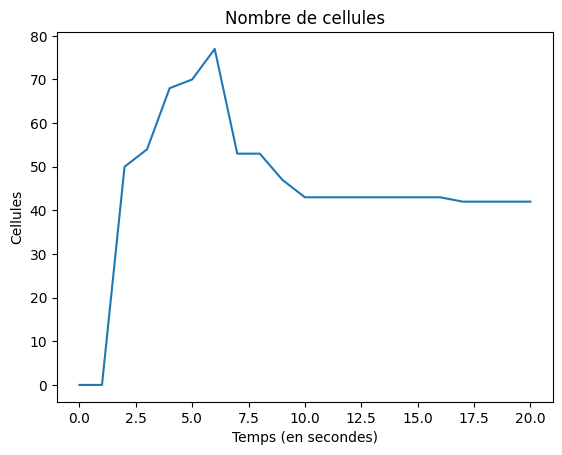

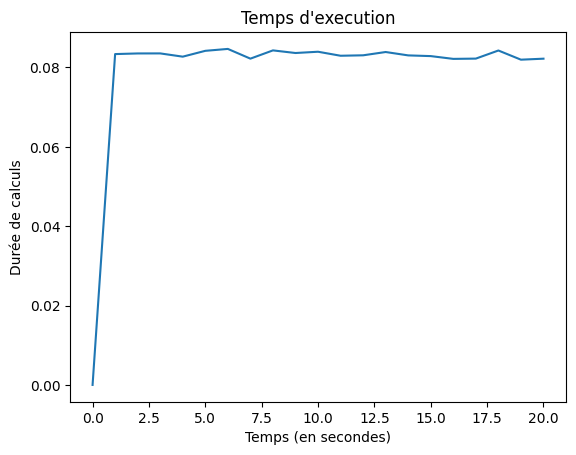

In [5]:
import matplotlib.pyplot as plt

# Exemple de data issu d'un test précédent
data = [[0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0], [0, 0, 50, 54, 68, 70, 77, 53, 53, 47, 43, 43, 43, 43, 43, 43, 43, 42, 42, 42, 42], [0, 0.08337, 0.08353, 0.08354, 0.08272, 0.08419, 0.08467, 0.08222, 0.0843, 0.08364, 0.08396, 0.08295, 0.08306, 0.08389, 0.08304, 0.08286, 0.08216, 0.08223, 0.08427, 0.08196, 0.08221], [100]]

def creer_graph(data):
    plt.title("Nombre de cellules")
    plt.plot(data[0], data[1])
    plt.xlabel('Temps (en secondes)')
    plt.ylabel('Cellules')
    plt.show()

def creer_graph_exec(data):
    plt.title("Temps d'execution")
    plt.plot(data[0], data[2])
    plt.xlabel('Temps (en secondes)')
    plt.ylabel('Durée de calculs')
    plt.show()

creer_graph(data)
creer_graph_exec(data)